In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../data/합천_댐기상종합데이터.csv", index_col='시간')
df.index = pd.to_datetime(df.index)
df['홍수기'] = 0
# 인덱스의 월과 일을 이용하여 '홍수기' 열 값 설정
df.loc[(df.index.month >= 6) & (df.index.month <= 9) & (df.index.day >= 21) & (df.index.day <= 20), '홍수기'] = 1

In [4]:
df_date = df.assign(month = df.index.month).assign(day_of_week = df.index.dayofweek).assign(week_of_year = df.index.isocalendar().week)

In [5]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

df_date = generate_cyclical_features(df_date, 'day_of_week', 7, 0)
df_date = generate_cyclical_features(df_date, 'month', 12, 1)
df_date = generate_cyclical_features(df_date, 'week_of_year', 52, 0)

df_date.head()

,전일유입량,저수량(현재),전일방류량(본댐),저수량차이,2일전유입량,3일전유입량,4일전유입량,5일전유입량,6일전유입량,7일전유입량,...,1일후평균강수량(mm),2일후평균강수량(mm),3일후평균강수량(mm),홍수기,sin_day_of_week,cos_day_of_week,sin_month,cos_month,sin_week_of_year,cos_week_of_year
시간,,,,,,,,,,,,,,,,,,,,,
2000-01-01,7.4,513.4,28.9,173.4,5.8,3.5,5.5,6.9,5.0,5.3,...,0.000000,0.000000,0.000000,0,-0.974928,-0.222521,0.0,1.0,0.0,1.0
2000-01-02,4.4,512.1,23.7,173.0,7.4,5.8,3.5,5.5,6.9,5.0,...,0.000000,0.000000,0.187500,0,-0.781831,0.623490,0.0,1.0,0.0,1.0
2000-01-03,4.7,509.8,26.1,171.8,4.4,7.4,5.8,3.5,5.5,6.9,...,0.000000,0.187500,1.020833,0,0.000000,1.000000,0.0,1.0,0.120537,0.992709
2000-01-04,3.8,508.4,27.3,171.4,4.7,4.4,7.4,5.8,3.5,5.5,...,0.187500,1.020833,0.135417,0,0.781831,0.623490,0.0,1.0,0.120537,0.992709
2000-01-05,6.1,506.5,25.2,170.4,3.8,4.7,4.4,7.4,5.8,3.5,...,1.020833,0.135417,0.000000,0,0.974928,-0.222521,0.0,1.0,0.120537,0.992709


In [6]:
#df = df[['전일유입량', '전일방류량(본댐)', '평균강수량(mm)', '당일유입량', '1일후유입량', '2일후유입량']]
df_date = df_date[['저수량(현재)', '평균기온(°C)', '평균습도(%)', '전일방류량(본댐)', '평균강수량(mm)', '홍수기', 'sin_day_of_week', 'cos_day_of_week', 'sin_month', 'cos_month', 'sin_week_of_year', 'cos_week_of_year', '당일유입량']]
#df.head(5)

In [7]:
df_date.columns

Index(['저수량(현재)', '평균기온(°C)', '평균습도(%)', '전일방류량(본댐)', '평균강수량(mm)', '홍수기',
       'sin_day_of_week', 'cos_day_of_week', 'sin_month', 'cos_month',
       'sin_week_of_year', 'cos_week_of_year', '당일유입량'],
      dtype='object')

In [8]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_date)

In [9]:
df_scaled = pd.DataFrame(data=scaled_data, columns=df_date.columns, index=df_date.index.values)
df_scaled.head()

,저수량(현재),평균기온(°C),평균습도(%),전일방류량(본댐),평균강수량(mm),홍수기,sin_day_of_week,cos_day_of_week,sin_month,cos_month,sin_week_of_year,cos_week_of_year,당일유입량
2000-01-01,0.582187,0.347890,0.553127,0.017042,0.000000,0.0,0.000000,0.356896,0.5,1.0,0.500000,1.000000,0.002319
2000-01-02,0.580059,0.421855,0.576004,0.013976,0.000000,0.0,0.099031,0.801938,0.5,1.0,0.500000,1.000000,0.002477
2000-01-03,0.576293,0.302154,0.462633,0.015391,0.000000,0.0,0.500000,1.000000,0.5,1.0,0.560268,0.996354,0.002003
2000-01-04,0.574001,0.273040,0.474835,0.016099,0.000000,0.0,0.900969,0.801938,0.5,1.0,0.560268,0.996354,0.003215
2000-01-05,0.570891,0.345530,0.546518,0.014860,0.005805,0.0,1.000000,0.356896,0.5,1.0,0.560268,0.996354,0.004217


In [10]:
train = df_scaled.loc['2000-01-01':'2021-01-01']
test = df_scaled.loc['2021-01-01':]

In [11]:
train_y = train[['당일유입량']]
test_y = test[['당일유입량']]

In [12]:
train_scaled = train.values
test_scaled = test.values
train_scaled_y = train_y.values
test_scaled_y = test_y.values

In [13]:
# 훈련 데이터셋에 대해 X와 y를 분리하고 3일 단위로 묶기
def split_sequence(sequence,sequence_y, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequence)):
        # 인덱스를 기준으로 입력 시퀀스와 출력 시퀀스를 나누기
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence_y[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# 훈련 및 테스트 데이터셋 생성
n_steps_in = 7
n_steps_out = 3
X_train, y_train = split_sequence(train_scaled,train_scaled_y, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_scaled,test_scaled_y, n_steps_in, n_steps_out)

In [26]:
from tensorflow.keras.optimizers.legacy import Adam

learning_rates = [0.001, 0.01]
units = [64, 128, 256, 512]
dropouts = [0.2, 0.5]
epochs = [1000]

In [27]:
timesteps = 7
eval = pd.DataFrame(columns=['RMSE', 'MAE', 'MSE', 'PBIAS', 'NSE'])
for lr in learning_rates:
  optimizer = Adam(learning_rate=lr)
  for u in units:
    for d in dropouts:
      for e in epochs:
        print("======================================================================================")
        print(f"units: {u}, dropout: {d}, epoch: {e}")

        model = Sequential()
        model.add(SimpleRNN(u, input_shape=(timesteps, X_train.shape[2]), return_sequences=True))
        model.add(Dropout(d)) 
        model.add(SimpleRNN(int(u/2)))
        model.add(Dropout(d))
        model.add(Dense(3))
        model.compile(loss='mse', optimizer=optimizer)
        model.fit(X_train, y_train, epochs=e, batch_size=32, verbose=0)
        
        y_pred = model.predict(X_test)
        y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

        #RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print('RMSE:', rmse, end="\t")
        #MAE
        mae = mean_absolute_error(y_test, y_pred)
        print('MAE:', mae, end="\t")
        #MSE
        mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
        print("MSE:", mse, end="\t")

        # PBIAS 계산
        diff = np.sum(y_pred - y_test)
        sum_observed = np.sum(y_test)
        pbias = (diff / sum_observed) * 100
        print('PBIAS:', pbias, end="\t")

        # NSE 계산
        diff_pred_obs = np.sum((y_pred - y_test) ** 2)
        diff_obs_mean = np.sum((y_test - np.mean(y_test)) ** 2)
        nse = 1 - (diff_pred_obs / diff_obs_mean)
        print('NSE:', nse, end="\t")
        print()

        array = [rmse, mae, mse, pbias, nse]
        eval.loc[eval.shape[0]] = array

        mae = np.mean(np.abs(y_test - y_pred), axis=0)
        mse = np.mean(np.square(y_test - y_pred), axis=0)
        plt.figure(figsize=(10, 6))
        plt.plot(mae, label="MAE")
        plt.plot(mse, label="MSE")
        plt.xlabel("Time Step")
        plt.ylabel("Error")
        plt.legend()
        plt.savefig(f"images/1_units_{u} dropout_{d} epoch_{e} lr_{lr}.png")
        plt.close()

        plt.figure(figsize=(16, 8))
        plt.plot(y_test, label="Actual")
        plt.plot(y_pred, label="Predicted")
        plt.legend()
        plt.savefig(f"images/2_units_{u} dropout_{d} epoch_{e} lr_{lr}.png")
        plt.close()

        y_test_df = pd.DataFrame(y_test)
        y_pred_df = pd.DataFrame(y_pred)

        test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]
        plt.figure(figsize=(16, 8))
        plt.plot(test_dates, y_test_df.iloc[:, 0], label='Actual')
        plt.plot(test_dates, y_pred_df.iloc[:, 0], label='Predicted', linestyle='--')
        plt.legend()
        plt.savefig(f"images/3_units_{u} dropout_{d} epoch_{e} lr_{lr}.png")
        plt.close()

        plt.figure(figsize=(16, 8))
        plt.plot(test_dates, y_test_df.iloc[:, 1], label='Actual')
        plt.plot(test_dates, y_pred_df.iloc[:, 1], label='Predicted', linestyle='--', color="#C71585")
        plt.legend()
        plt.savefig(f"images/4_units_{u} dropout_{d} epoch_{e} lr_{lr}.png")
        plt.close()

        plt.figure(figsize=(16, 8))
        plt.plot(test_dates, y_test_df.iloc[:, 2], label='Actual')
        plt.plot(test_dates, y_pred_df.iloc[:, 2], label='Predicted', linestyle='--', color="#FA8072")
        plt.legend()
        plt.savefig(f"images/5_units_{u} dropout_{d} epoch_{e} lr_{lr}.png")
        plt.close()

        # 날짜 범위 생성
        train_dates = df_scaled.index[n_steps_in:n_steps_in+len(X_train)]
        test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]

        plt.figure(figsize=(10, 6))
        plt.plot(train_dates, y_train[:, 0], label='Actual (Train)', color='blue')
        plt.plot(test_dates, y_test[:, 0], label='Actual (Test)', color='green')
        plt.plot(test_dates, y_pred[:, 0], label='Predicted', color='red')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title('Actual vs Predicted')
        plt.gcf().autofmt_xdate()
        plt.legend()
        plt.savefig(f"images/6_units_{u} dropout_{d} epoch_{e} lr_{lr}.png")
        plt.close()

units: 64, dropout: 0.2, epoch: 1000
26/26 [==============================] - 0s 648us/step
RMSE: 0.01598685206094466	MAE: 0.009019425590174003	MSE: 0.0002555794388185305	PBIAS: 149.33560179548527	NSE: -0.4137259746505555	
units: 64, dropout: 0.5, epoch: 1000
26/26 [==============================] - 0s 688us/step
RMSE: 0.013126785372393757	MAE: 0.0050837937036294625	MSE: 0.00017231249421289073	PBIAS: 52.57519116762851	NSE: 0.04686132048927161	
units: 128, dropout: 0.2, epoch: 1000
26/26 [==============================] - 0s 811us/step
RMSE: 0.013686787020168354	MAE: 0.0049706899068970275	MSE: 0.0001873281389354489	PBIAS: 13.412512830276032	NSE: -0.036197031420944326	
units: 128, dropout: 0.5, epoch: 1000
26/26 [==============================] - 0s 735us/step
RMSE: 0.013351185188504101	MAE: 0.0057295041273769005	MSE: 0.0001782541459377312	PBIAS: 61.220918212259846	NSE: 0.013995345767031098	
units: 256, dropout: 0.2, epoch: 1000
26/26 [==============================] - 0s 1ms/step
RMSE: 

In [ ]:
from tensorflow.keras.layers import Dropout

timesteps = 7
model = Sequential()
model.add(SimpleRNN(256, input_shape=(timesteps, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout 레이어 추가
model.add(SimpleRNN(128))
model.add(Dropout(0.2))
model.add(Dense(3))
model.compile(loss='mse', optimizer=optimizer)
model.fit(X_train, y_train, epochs=250, batch_size=32, verbose=1)

In [79]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 7, 256)            69120     
                                                                 
 dropout_4 (Dropout)         (None, 7, 256)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 3)                 387       
                                                                 
Total params: 118,787
Trainable params: 118,787
Non-trainable params: 0
_________________________________________________________________


In [65]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_test.shape)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

26/26 [==============================] - 0s 3ms/step
(816, 3)
(816, 3, 1)


In [78]:

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
print("MSE:", mse)
# PBIAS 계산
diff = np.sum(y_pred - y_test)
sum_observed = np.sum(y_test)
pbias = (diff / sum_observed) * 100

print('PBIAS:', pbias)
# NSE 계산
diff_pred_obs = np.sum((y_pred - y_test) ** 2)
diff_obs_mean = np.sum((y_test - np.mean(y_test)) ** 2)
nse = 1 - (diff_pred_obs / diff_obs_mean)

print('NSE:', nse)

RMSE: 0.012563398629280458
MAE: 0.005148755263580335
MSE: 0.0001578389851182061
PBIAS: 2.5904795099696263
NSE: 0.12692087397324758


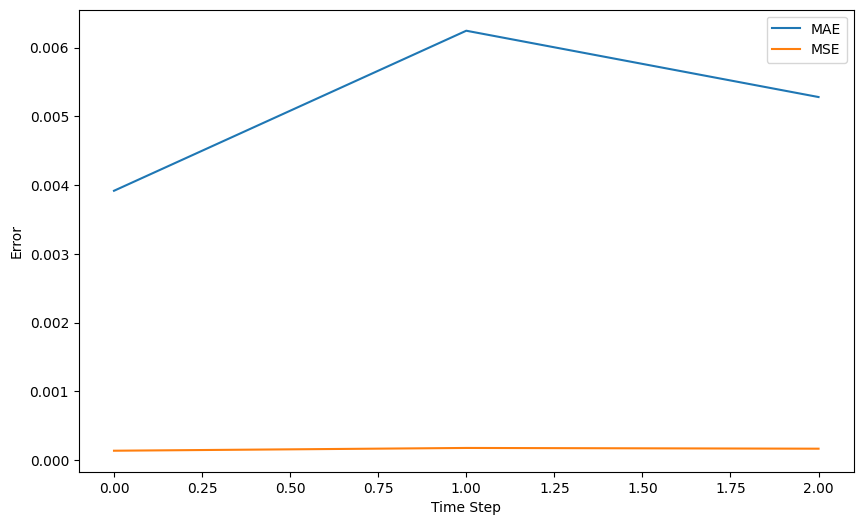

In [71]:
import matplotlib.pyplot as plt

# MAE와 MSE 값 계산
mae = np.mean(np.abs(y_test - y_pred), axis=0)
mse = np.mean(np.square(y_test - y_pred), axis=0)

# 그래프 그리기
plt.figure(figsize=(10,6))
plt.plot(mae, label='MAE')
plt.plot(mse, label='MSE')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()
plt.show()


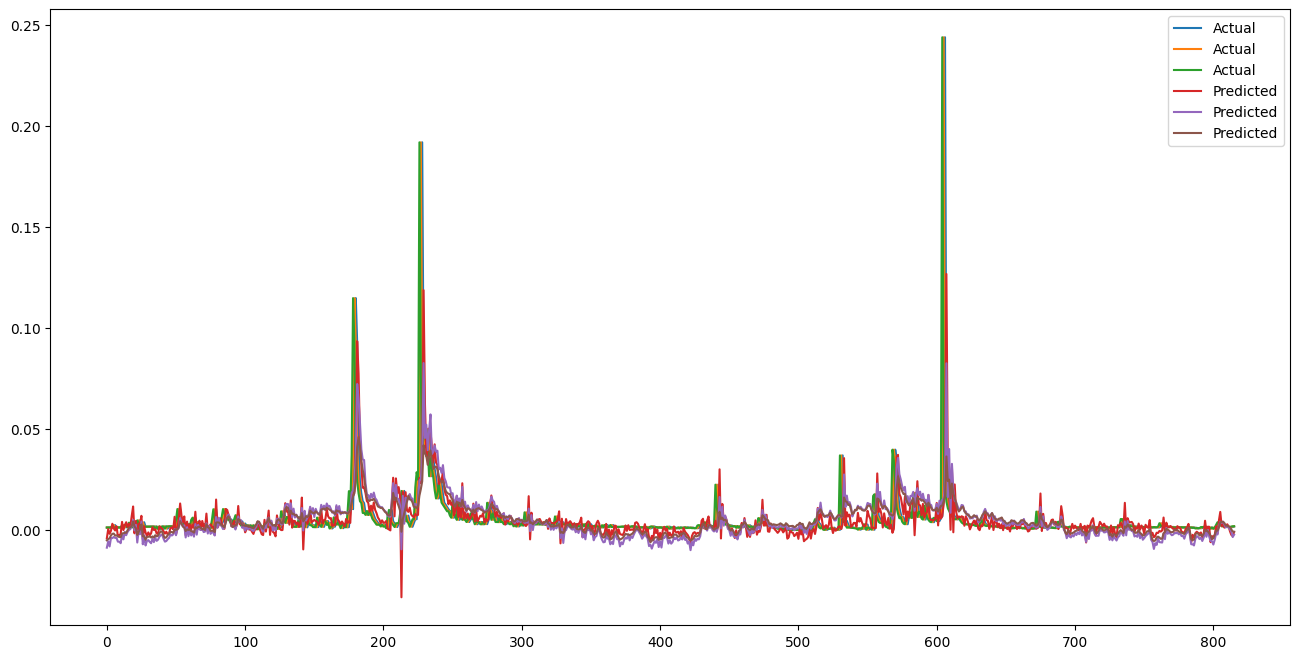

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [73]:
#y_test_original = scaler.inverse_transform(y_test[0])
y_test_df = pd.DataFrame(y_test)
#y_test_df.head()
y_pred_df = pd.DataFrame(y_pred)
test.index #1556
y_test_df.shape #1547

(816, 3)

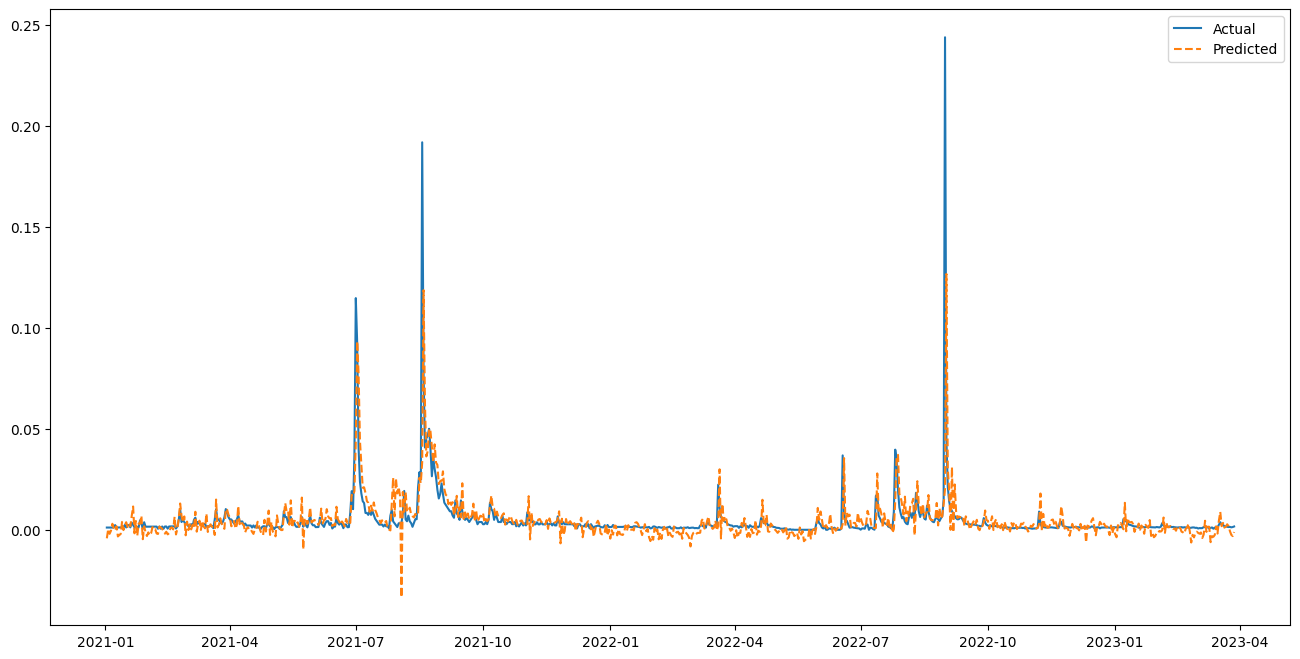

In [74]:
import matplotlib.pyplot as plt
test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]


plt.figure(figsize=(16,8))
plt.plot(test_dates, y_test_df.iloc[:, 0], label='Actual')
plt.plot(test_dates, y_pred_df.iloc[:, 0], label='Predicted', linestyle='--')
plt.legend()
#plt.title('당일 유입량 예측')
plt.show()

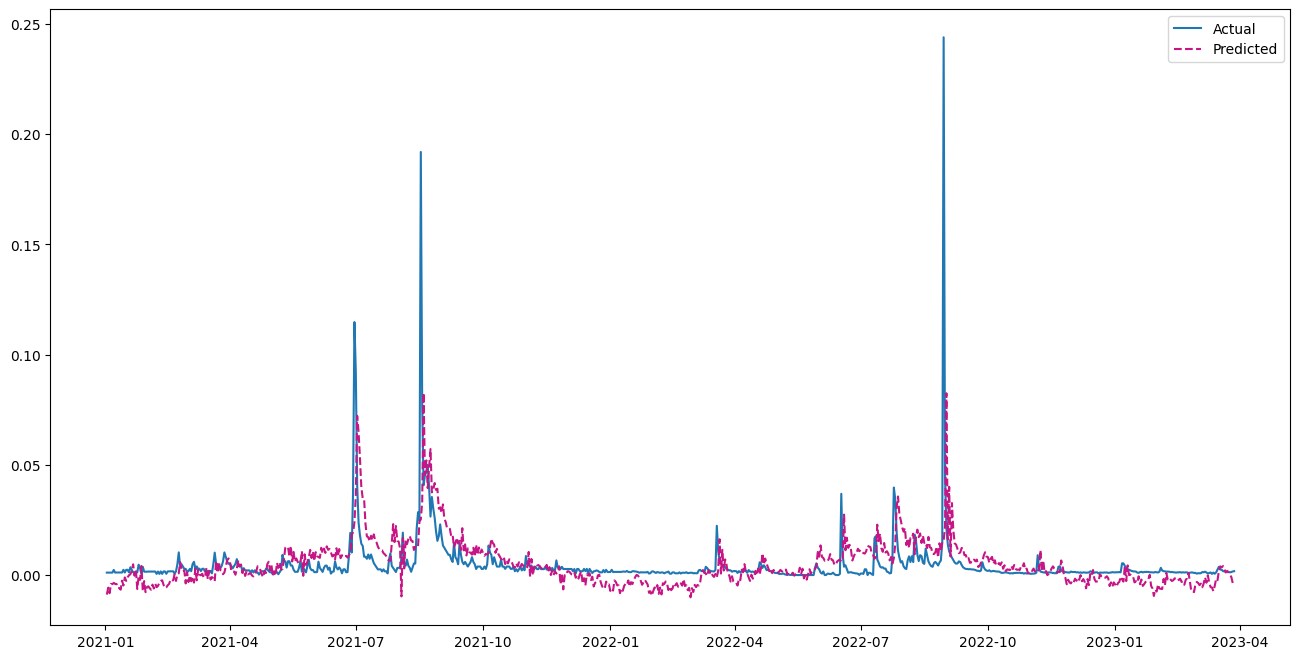

In [75]:
import matplotlib.pyplot as plt
test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]


plt.figure(figsize=(16,8))
plt.plot(test_dates, y_test_df.iloc[:, 1], label='Actual')
plt.plot(test_dates, y_pred_df.iloc[:, 1], label='Predicted', linestyle='--', color='#C71585')
plt.legend()
#plt.title('1일 후 유입량 예측')
plt.show()

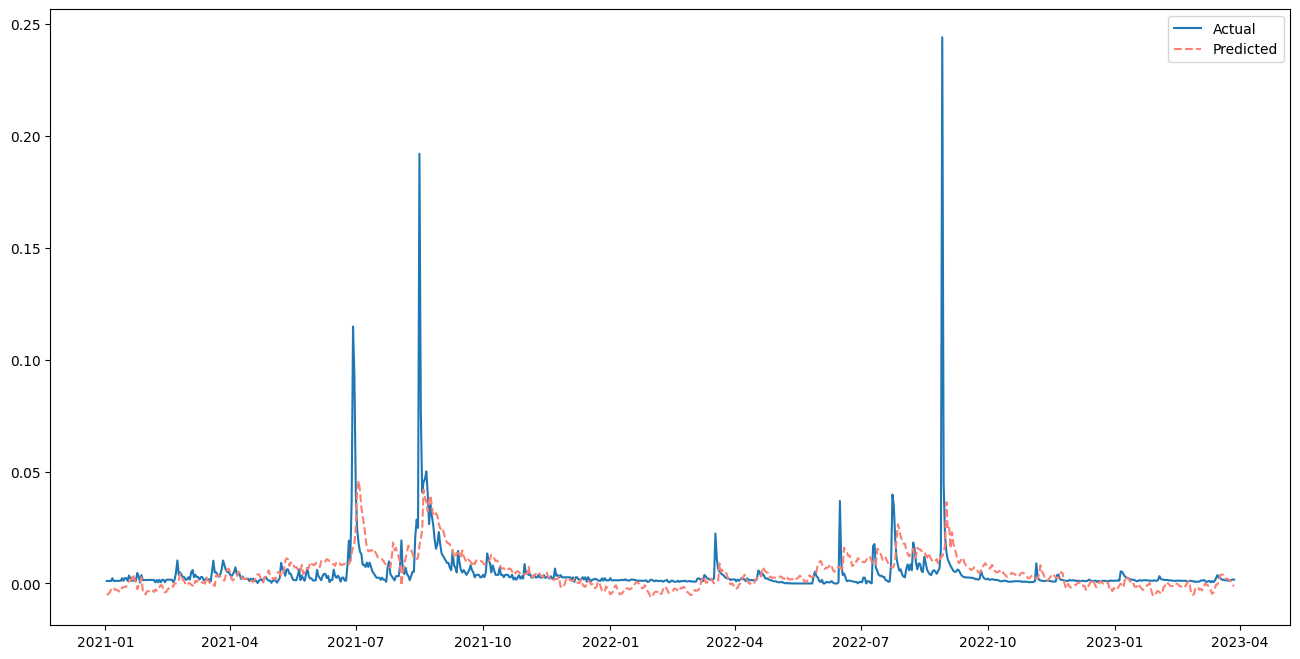

In [76]:
import matplotlib.pyplot as plt
test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]


plt.figure(figsize=(16,8))
plt.plot(test_dates, y_test_df.iloc[:, 2], label='Actual')
plt.plot(test_dates, y_pred_df.iloc[:, 2], label='Predicted', linestyle='--', color='#FA8072')
plt.legend()
#plt.title('2일 후 유입량 예측')
plt.show()

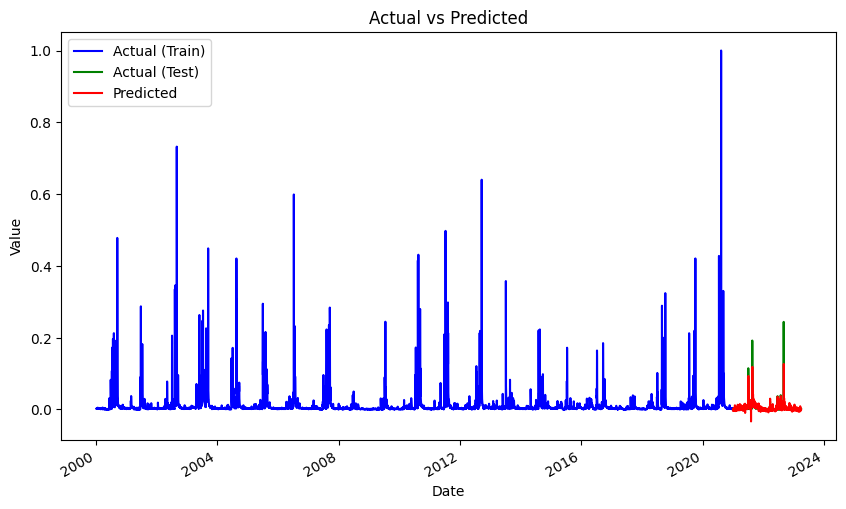

In [77]:
import matplotlib.pyplot as plt

# 날짜 범위 생성
train_dates = df_scaled.index[n_steps_in:n_steps_in+len(X_train)]
test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(train_dates, y_train[:, 0], label='Actual (Train)', color='blue')
plt.plot(test_dates, y_test[:, 0], label='Actual (Test)', color='green')
plt.plot(test_dates, y_pred[:, 0], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()


AttributeError: ignored

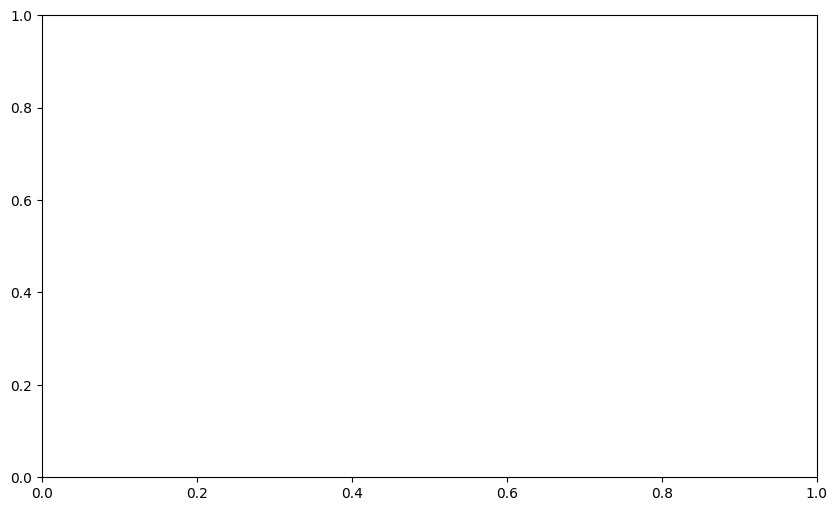

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# 연도별로 날짜 범위 생성
train_years = pd.to_datetime(train_dates).year.unique()
test_years = pd.to_datetime(test_dates).year.unique()

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))

# 훈련 데이터 그래프 그리기
for year in train_years:
    train_year_dates = train_dates[train_dates.year == year]
    train_year_values = y_train[train_dates.year == year, 0]
    ax.plot(train_year_dates, train_year_values, label=f'Actual (Train) - {year}', color='blue')

# 테스트 데이터 그래프 그리기
for year in test_years:
    test_year_dates = test_dates[test_dates.year == year]
    test_year_values = y_test[test_dates.year == year, 0]
    ax.plot(test_year_dates, test_year_values, label=f'Actual (Test) - {year}', color='green')

# 예측 값 그래프 그리기
ax.plot(test_dates, y_pred[:, 0], label='Predicted', color='red')

# x축 레이블 설정
ax.xaxis.set_major_locator(MultipleLocator(base=365))  # 1년마다 눈금 설정
ax.xaxis.set_major_formatter(plt.FixedFormatter([str(year) for year in train_years]))  # 연도로 표기

# 그래프 설정
ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.set_title('Actual vs Predicted')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(df_scaled.shape)

(8496, 40)
